In [3]:
%matplotlib inline

import glob
from platform import python_version
import pandas as pd
import matplotlib
import numpy as np
import sklearn
import torch
import matplotlib.pyplot as plt

In [4]:
torch.cuda.empty_cache()

In [5]:
print("python version==%s" % python_version())
print("pandas==%s" % pd.__version__)
print("numpy==%s" % np.__version__)
print("sklearn==%s" % sklearn.__version__)
print("torch==%s" % torch.__version__)
print("matplotlib==%s" % matplotlib.__version__)

python version==3.11.6
pandas==2.1.2
numpy==1.26.1
sklearn==1.3.2
torch==2.1.0+cpu
matplotlib==3.8.1


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [7]:
#load data
data = pd.read_csv("..\\..\\Data\\Minute\\2010-2014-SANDP-500.txt")

In [8]:
data

,Date,Open,High,Low,Close
0,1262626320,1122.87,1123.80,1122.87,1123.80
1,1262626380,1123.95,1124.18,1123.95,1124.18
2,1262626440,1124.27,1124.27,1124.07,1124.07
3,1262626500,1124.17,1124.26,1124.17,1124.26
4,1262626560,1124.63,1124.63,1124.63,1124.63
...,...,...,...,...,...
392945,1388538060,1847.43,1848.35,1847.43,1848.35
392946,1388538120,1848.35,1848.36,1848.35,1848.36
392947,1388538180,1848.35,1848.36,1848.35,1848.36
392948,1388542560,1848.36,1848.36,1848.36,1848.36


In [9]:
#transform data
data = data.replace(",", "", regex=True)
data.Date = pd.to_datetime(data.Date * 1e9)
data = data.sort_values(by=["Date"])
data.Close = data.Close.astype(float)
data.High = data.High.astype(float)
data.Low = data.Low.astype(float)
data.Open = data.Open.astype(float)

In [10]:
data.index = data.index[::-1]

In [11]:
data.head()

,Date,Open,High,Low,Close
392949,2010-01-04 17:32:00,1122.87,1123.80,1122.87,1123.80
392948,2010-01-04 17:33:00,1123.95,1124.18,1123.95,1124.18
392947,2010-01-04 17:34:00,1124.27,1124.27,1124.07,1124.07
392946,2010-01-04 17:35:00,1124.17,1124.26,1124.17,1124.26
392945,2010-01-04 17:36:00,1124.63,1124.63,1124.63,1124.63


In [12]:
special_data = data[(data['Date'] > '2010-01-01') & (data['Date'] < '2015-01-01')]

In [13]:
special_data.head(10)

,Date,Open,High,Low,Close
392949,2010-01-04 17:32:00,1122.87,1123.80,1122.87,1123.80
392948,2010-01-04 17:33:00,1123.95,1124.18,1123.95,1124.18
392947,2010-01-04 17:34:00,1124.27,1124.27,1124.07,1124.07
392946,2010-01-04 17:35:00,1124.17,1124.26,1124.17,1124.26
392945,2010-01-04 17:36:00,1124.63,1124.63,1124.63,1124.63
392944,2010-01-04 17:37:00,1126.30,1126.30,1126.18,1126.29
392943,2010-01-04 17:38:00,1126.50,1126.75,1126.50,1126.75
392942,2010-01-04 17:39:00,1126.69,1126.74,1126.68,1126.68
392941,2010-01-04 17:40:00,1126.54,1126.64,1126.54,1126.64
392940,2010-01-04 17:41:00,1126.92,1126.92,1126.92,1126.92


In [14]:
#change indexes
special_data.set_index('Date', inplace=True)

In [15]:
special_data = special_data.drop(columns=['Open', 'High', 'Low'])

In [16]:
special_data = special_data.dropna()

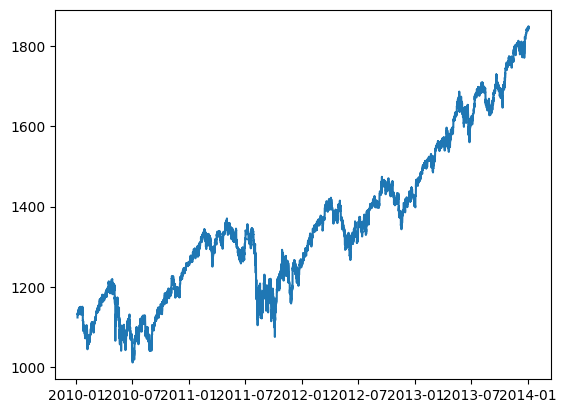

In [17]:
plt.plot(special_data)

In [18]:
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

def sliding_windows(data, seq_length):
    x = []
    y = []
    print(len(data), seq_length)
    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(special_data)

seq_length = 100
x, y = sliding_windows(training_data, seq_length)
print(x.shape, y.shape)
train_size = int(len(y) * 0.7)
val_size = 100
test_size = len(y) - train_size - val_size

dataX = Variable(torch.Tensor(np.array(x)).to(device))
dataY = Variable(torch.Tensor(np.array(y)).to(device))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])).to(device))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])).to(device))

testX = Variable(torch.Tensor(np.array(x[train_size:(len(x) - val_size)])).to(device))
testY = Variable(torch.Tensor(np.array(y[train_size:(len(y) - val_size)])).to(device))

valX = Variable(torch.Tensor(np.array(x[(len(x) - val_size):len(x)])).to(device))
valY = Variable(torch.Tensor(np.array(y[(len(x) - val_size):len(y)])).to(device))

392950 100
(392849, 100, 1) (392849, 1)


In [48]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_dataset = TimeSeriesDataset(trainX, trainY)
test_dataset = TimeSeriesDataset(testX, testY)
val_dataset = TimeSeriesDataset(valX, valY)

train_loader = DataLoader(train_dataset, batch_size = 10000, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = 10000, shuffle = False)
val_loader = DataLoader(val_dataset, batch_size = 10000, shuffle = False)

In [49]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Propagate input through LSTM
        _, (h_out, _) = self.lstm(x, (h_0, c_0))
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        return out

In [50]:
train_loader

28
Before train
After Train
Before torch.no_grad
Epoch [1/90], Train Loss: 0.0183, Valid Loss: 0.0484
Before train
After Train
Before torch.no_grad
Before train
After Train
Before torch.no_grad
Before train
After Train
Before torch.no_grad
Before train
After Train
Before torch.no_grad
Before train
After Train
Before torch.no_grad
Before train
After Train
Before torch.no_grad
Before train
After Train
Before torch.no_grad
Before train
After Train
Before torch.no_grad
Before train
After Train
Before torch.no_grad
Before train
After Train
Before torch.no_grad
Epoch [11/90], Train Loss: 0.0005, Valid Loss: 0.0047
Before train
After Train
Before torch.no_grad
Before train
After Train
Before torch.no_grad
Before train
After Train
Before torch.no_grad
Before train
After Train
Before torch.no_grad
Before train
After Train
Before torch.no_grad
Before train
After Train
Before torch.no_grad
Before train
After Train
Before torch.no_grad
Before train
After Train
Before torch.no_grad
Before train
Aft

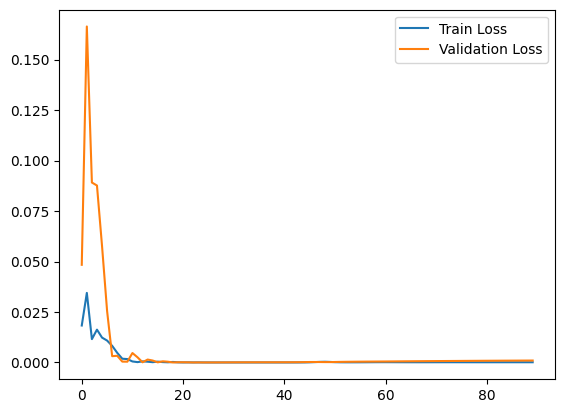

In [51]:
num_epochs = 90
learning_rate = 0.001

input_size = 1
hidden_size = 64 # need to find correct value ; 40 small, 64 norm, 100 a lot
num_layers = 1

num_classes = 1

model = LSTM(num_classes, input_size, hidden_size, num_layers).to(device)

# Define loss and optimizer
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr = learning_rate)

train_loss = []
valid_loss = []
print(train_loader.__len__())
for epoch in range(num_epochs):
    print("Before train")
    model.train()
    print("After Train")
    total_train_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        output = model(batch_x)
        loss = criterion(output, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
    
    average_train_loss = total_train_loss / len(train_loader)
    train_loss.append(average_train_loss)

    model.eval()
    total_valid_loss = 0
    print("Before torch.no_grad")
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            
            output = model(batch_x)
            loss = criterion(output, batch_y)

            total_valid_loss += loss.item()

    average_valid_loss = total_valid_loss / len(test_loader)
    valid_loss.append(average_valid_loss)

    if epoch % 10 == 0:
        print('Epoch [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}'.format(
            epoch+1, num_epochs, train_loss[-1], valid_loss[-1]))

# plot train and validation loss
plt.plot(train_loss, label = 'Train Loss')
plt.plot(valid_loss, label = 'Validation Loss')
plt.legend()
plt.show()

In [53]:
len(testX)

117755

In [56]:
from sklearn.metrics import mean_squared_error
# Test the model
model.eval()
test_predict = model(valX)

test_predict_inv = sc.inverse_transform(test_predict.cpu().detach().numpy())
testY_inv = sc.inverse_transform(testY.cpu().detach().numpy())

test_score = np.sqrt(mean_squared_error(valY, test_predict_inv))
print("Test RMSE Score: %.2f" % test_score)

Test RMSE Score: 1782.33


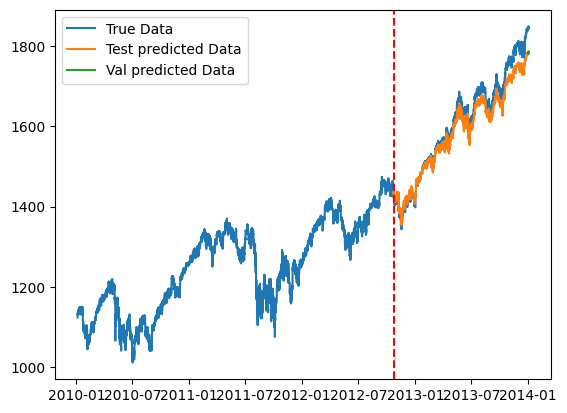

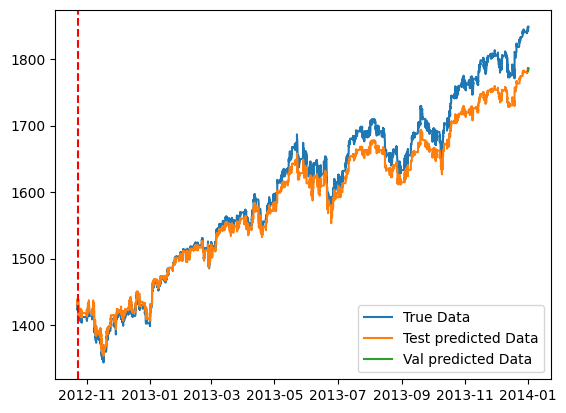

In [57]:
import matplotlib.pyplot as plt

# make predictions
predY_test = model(testX)
predY_val = model(valX)

# invert scaling for forecast
predY_test_inv = sc.inverse_transform(predY_test.cpu().detach().numpy())
predY_val_inv = sc.inverse_transform(predY_val.cpu().detach().numpy())
testY_inv = sc.inverse_transform(testY.cpu().detach().numpy())
# plot 1
plt.plot(special_data, label='True Data')
plt.plot(special_data.index[-len(predY_test_inv)- val_size: - val_size], predY_test_inv, label='Test predicted Data')
plt.plot(special_data.index[-len(predY_val_inv):], predY_val_inv, label='Val predicted Data')
plt.axvline(x = special_data.index[-len(predY_test_inv)- val_size], c='r', linestyle='--')
plt.legend()
plt.show()
# plot 2
plt.plot(special_data.index[-len(predY_test_inv)- val_size:], special_data.Close[-len(predY_test_inv)- val_size:], label='True Data')
plt.plot(special_data.index[-len(predY_test_inv)- val_size: - val_size], predY_test_inv, label = 'Test predicted Data')
plt.plot(special_data.index[-len(predY_val_inv):], predY_val_inv, label='Val predicted Data')
plt.axvline(x = special_data.index[-len(predY_test_inv)- val_size], c = 'r', linestyle = '--')
plt.legend()
plt.show()

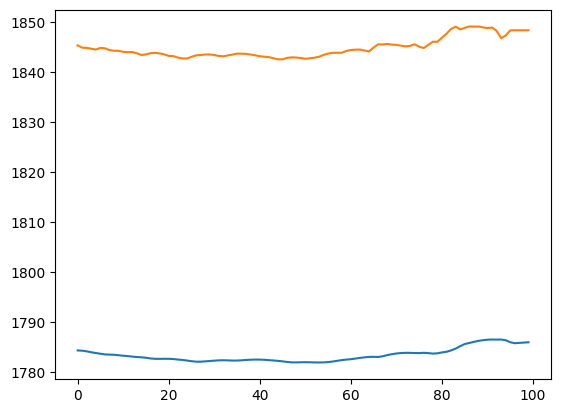

In [70]:
plt.plot(predY_val_inv)
plt.plot(special_data.Close[-val_size:].values)

In [60]:
len(testY_inv)

117755

In [61]:
len(test_predict_inv)

100

In [83]:
np.array(predY_val_inv)

array([[1784.2655],
       [1784.2135],
       [1784.0844],
       [1783.8947],
       [1783.7443],
       [1783.6003],
       [1783.4609],
       [1783.4292],
       [1783.3934],
       [1783.2986],
       [1783.2006],
       [1783.1263],
       [1783.0287],
       [1782.9454],
       [1782.889 ],
       [1782.7976],
       [1782.6606],
       [1782.5841],
       [1782.579 ],
       [1782.5934],
       [1782.5846],
       [1782.54  ],
       [1782.4402],
       [1782.3588],
       [1782.2373],
       [1782.1101],
       [1782.0122],
       [1782.0125],
       [1782.079 ],
       [1782.1434],
       [1782.2191],
       [1782.2778],
       [1782.298 ],
       [1782.2694],
       [1782.2333],
       [1782.242 ],
       [1782.2836],
       [1782.3555],
       [1782.406 ],
       [1782.4352],
       [1782.4286],
       [1782.3909],
       [1782.319 ],
       [1782.2474],
       [1782.1772],
       [1782.0756],
       [1781.959 ],
       [1781.873 ],
       [1781.8693],
       [1781.8928],


In [84]:
deviations = np.abs(predY_val_inv.flatten() - special_data.Close[-val_size:])
max_deviation = np.max(deviations)

In [85]:
print(max_deviation)

64.44608886718743


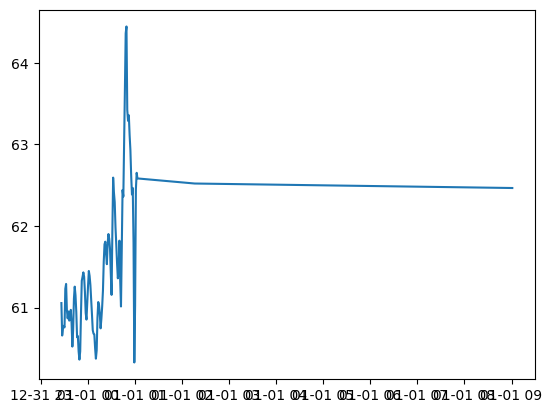

In [86]:
plt.plot(deviations)

In [87]:
percent_deviations = (special_data.Close[-val_size:] - predY_val_inv.flatten()) / special_data.Close[-val_size:]
max_percent_deviations = np.max(percent_deviations)

In [88]:
max_percent_deviations

0.03485305604256572

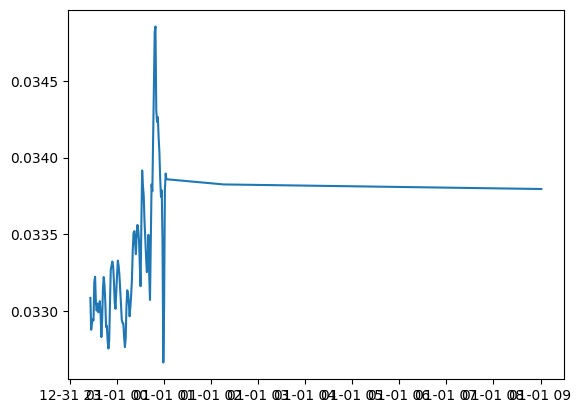

In [89]:
plt.plot(percent_deviations)